In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import statsmodels.api as sm
from PyEMD import EMD
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [19]:
FORECAST_STEPS = 60
ticker = "^IXIC"
data = yf.download(ticker, start="2012-01-01", end="2017-01-01")
copy_adj_close = data['Adj Close'].to_numpy()

[*********************100%%**********************]  1 of 1 completed


In [9]:
emd = EMD()
eIMFs = emd(copy_adj_close)

In [10]:
def apply_sarimax(data, order, forecast_steps):
    model = sm.tsa.statespace.SARIMAX(data, order=order, seasonal_order=(0,0,0,0),
                                      enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(maxiter=2000)
    forecast = model_fit.forecast(steps=forecast_steps)
    return forecast

eIMFs_sarimax_results = []

for eimf in eIMFs:
    forecast = apply_sarimax(eimf[:-FORECAST_STEPS], order=(10,1,1), forecast_steps=FORECAST_STEPS)
    eIMFs_sarimax_results.append(forecast)
    

In [11]:
# Holt's Linear Exponential Smoothing
eIMFs_HLES_forecast = []
for eimf in eIMFs:
    data = eimf.squeeze()
    model = ExponentialSmoothing(data, trend='add', seasonal='add', seasonal_periods=365)
    model_fit = model.fit(smoothing_level=0.01, smoothing_trend=0.01, smoothing_seasonal=0.01, optimized=False)
    forecast = model_fit.forecast(steps=FORECAST_STEPS)
    eIMFs_HLES_forecast.append(forecast)

In [12]:
# series to supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    cols = []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    agg.dropna(inplace=True)
    return agg.values

In [13]:
# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x.view(len(x), -1, 1), (h0.detach(), c0.detach()))
        out = self.linear(out[:, -1, :])
        return out

In [14]:
# train and test
eIMFs_lstm_results = []
for data in eIMFs:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    reframed = series_to_supervised(scaled_data, 1, 1)
    
    train = reframed[:-FORECAST_STEPS]
    test = reframed[-FORECAST_STEPS:]

    train_X, train_y = torch.FloatTensor(train[:, :-1]), torch.FloatTensor(train[:, -1])
    test_X, test_y = torch.FloatTensor(test[:, :-1]), torch.FloatTensor(test[:, -1])
    
    model = LSTMModel(input_dim = 1, hidden_dim = 32, num_layers = 2, output_dim = 1)
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    
    # train
    num_epochs = 5000
    for epoch in range(num_epochs):
        outputs = model(train_X)
        outputs = outputs.squeeze()
        optimizer.zero_grad()
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()
    
    # forecasting (test)
    with torch.no_grad():
        test_outputs = model(test_X)
        test_outputs = scaler.inverse_transform(test_outputs.numpy())
    eIMFs_lstm_results.append(test_outputs)

In [15]:
# back from IMFs
lstm_forecast = np.sum(eIMFs_lstm_results, axis = 0).squeeze()

sarimax_forecast = np.sum(eIMFs_sarimax_results, axis=0).squeeze()

HLES_forecast = np.sum(eIMFs_HLES_forecast, axis=0).squeeze()


In [16]:
# weighted forecasting based on errors
errors_lstm = lstm_forecast - copy_adj_close[-FORECAST_STEPS:]
errors_sarimax = sarimax_forecast - copy_adj_close[-FORECAST_STEPS:]
errors_HLES = HLES_forecast - copy_adj_close[-FORECAST_STEPS:]

weights_lstm = 1 / (np.abs(errors_lstm) + 1e-10)
weights_sarimax = 1 / (np.abs(errors_sarimax) + 1e-10)
weights_HLES = 1 / (np.abs(errors_HLES) + 1e-10)

ensemble_predictions_LSTM_SARIMAX = (lstm_forecast * weights_lstm + sarimax_forecast * weights_sarimax) / (weights_lstm + weights_sarimax)
ensemble_predictions_LSTM_HLES = (lstm_forecast * weights_lstm + HLES_forecast * weights_HLES) / (weights_lstm + weights_HLES)


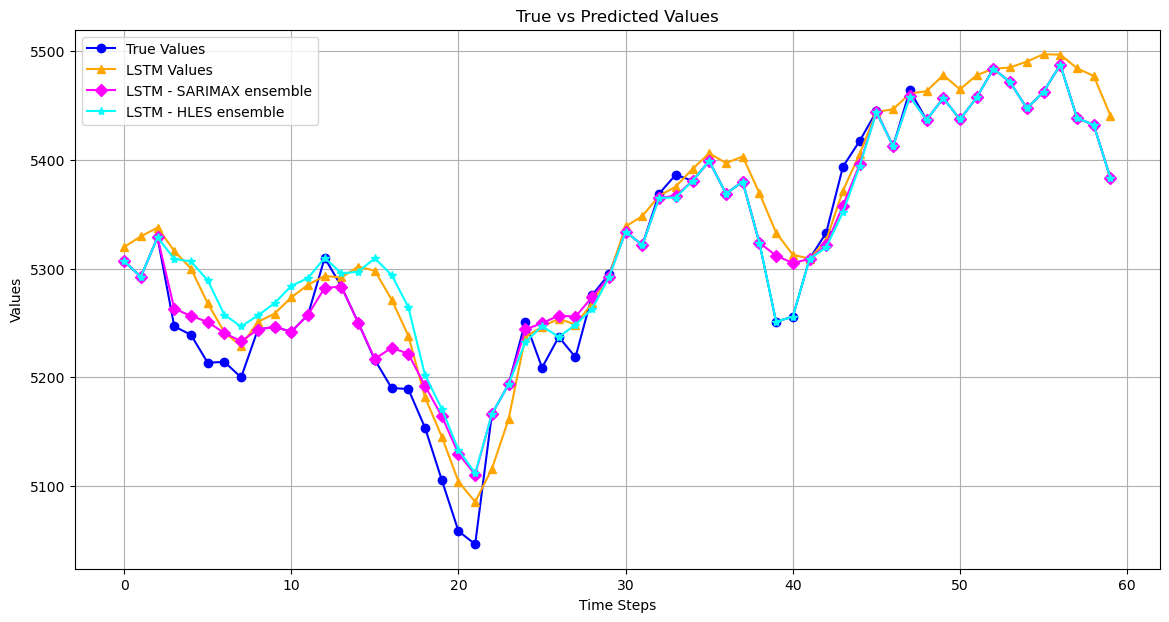

In [17]:
# plot

plt.figure(figsize=(14, 7))
plt.plot(copy_adj_close[-FORECAST_STEPS:], label='True Values', marker='o', color='blue')

plt.plot(lstm_forecast, label='LSTM Values', marker='^', color='orange')
plt.plot(ensemble_predictions_LSTM_SARIMAX, label='LSTM - SARIMAX ensemble', marker='D', color='magenta')
plt.plot(ensemble_predictions_LSTM_HLES, label='LSTM - HLES ensemble', marker='*', color='cyan')

plt.title('True vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
ensemble_errors_LSTM_SARIMAX = ensemble_predictions_LSTM_SARIMAX - copy_adj_close[-FORECAST_STEPS:]
ensemble_errors_LSTM_HLES = ensemble_predictions_LSTM_HLES - copy_adj_close[-FORECAST_STEPS:]

# metrics for model evaluation:

rmse_ensemble_LSTM_SARIMAX = np.sqrt((ensemble_errors_LSTM_SARIMAX ** 2).mean())
rmse_ensemble_LSTM_HLES = np.sqrt((ensemble_errors_LSTM_HLES ** 2).mean())
rmse_lstm = np.sqrt((errors_lstm ** 2).mean())
print("RMSE LSTM-SARIMAX: ", rmse_ensemble_LSTM_SARIMAX)
print("RMSE LSTM-HLES: ", rmse_ensemble_LSTM_HLES)
print("RMSE LSTM: ", rmse_lstm)

mae_lstm = np.abs(errors_lstm).mean()
mae_ensemble_LSTM_SARIMAX = np.abs(ensemble_errors_LSTM_SARIMAX).mean()
mae_ensemble_LSTM_HLES = np.abs(ensemble_errors_LSTM_HLES).mean()
print("MAE LSTM-SARIMAX: ", mae_ensemble_LSTM_SARIMAX)
print("MAE LSTM-HLES: ", mae_ensemble_LSTM_HLES)
print("MAE LSTM: ", mae_lstm)

mape_lstm = (np.abs(errors_lstm / copy_adj_close[-FORECAST_STEPS:]) * 100).mean()
mape_ensemble_LSTM_SARIMAX = (np.abs(ensemble_errors_LSTM_SARIMAX / copy_adj_close[-FORECAST_STEPS:]) * 100).mean()
mape_ensemble_LSTM_HLES = (np.abs(ensemble_errors_LSTM_HLES / copy_adj_close[-FORECAST_STEPS:]) * 100).mean()
print("MAPE LSTM-SARIMAX: ", mape_ensemble_LSTM_SARIMAX)
print("MAPE LSTM-HLES model: ", mape_ensemble_LSTM_HLES)
print("MAPE LSTM model: ", mape_lstm)


RMSE LSTM-SARIMAX:  23.464105776519364
RMSE LSTM-HLES:  34.5628769055385
RMSE LSTM:  35.87304245573584
MAE LSTM-SARIMAX:  12.991950459745778
MAE LSTM-HLES:  20.0681555912245
MAE LSTM:  28.860465494791665
MAPE LSTM-SARIMAX:  0.24964120806690027
MAPE LSTM-HLES model:  0.3853731946084392
MAPE LSTM model:  0.5470956453331265
